<a href="https://colab.research.google.com/github/akin-oladejo/self-driving-modules/blob/main/hough-lane-detection/hough_lane_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hough Lane Detection
Below is the code to detect lanes in a short driving video recorded on the Lagos-Ibadan Expressway. It uses Canny Edge Detection for line detection and the Hough transform to determine lane lines.

You would probably have to tweak parameters to get the lanes in a different video.

In [ ]:
!pip install av # install the av backend for imageio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.0/31.0 MB 45.5 MB/s eta 0:00:00


In [ ]:
# import libraries
import imageio.v3 as iio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

In [ ]:
# bulk read all frames
frames = iio.imread("lane_driving.mp4", plugin="pyav")

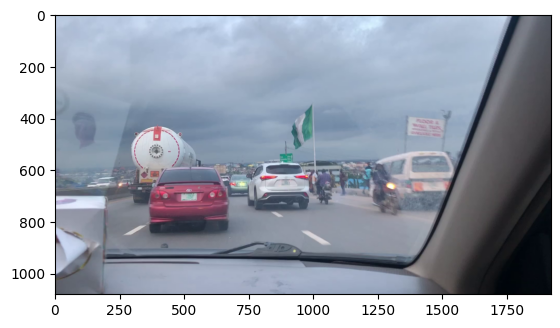

In [ ]:
img = frames[0]
plt.imshow(img)

In [ ]:
help(cv2.Canny)

Help on built-in function Canny:

Canny(...)
    Canny(image, threshold1, threshold2[, edges[, apertureSize[, L2gradient]]]) -> edges
    .   @brief Finds edges in an image using the Canny algorithm @cite Canny86 .
    .   
    .   The function finds edges in the input image and marks them in the output map edges using the
    .   Canny algorithm. The smallest value between threshold1 and threshold2 is used for edge linking. The
    .   largest value is used to find initial segments of strong edges. See
    .   <http://en.wikipedia.org/wiki/Canny_edge_detector>
    .   
    .   @param image 8-bit input image.
    .   @param edges output edge map; single channels 8-bit image, which has the same size as image .
    .   @param threshold1 first threshold for the hysteresis procedure.
    .   @param threshold2 second threshold for the hysteresis procedure.
    .   @param apertureSize aperture size for the Sobel operator.
    .   @param L2gradient a flag, indicating whether a more accurate \

In [ ]:
def plot_lanes(image,
               canny_low:int = 50,
               canny_high:int = 100,
               kernel_size:int = 5,
               rho:float|int = 1,
               theta:float = np.pi/180,
               hough_threshold:int = 1,
               min_line_length:int = 5,
               max_line_gap:int = 1):
    """
    image. image array

    Canny Edge Detection Parameters
    ====
    canny_low.
    canny_high.

    Hough Transform Parameters
    ====
    rho. distance resolution in pixels of the Hough grid
    theta. angular resolution in radians of the Hough grid
    threshold. minimum number of votes (intersections in Hough grid cell)
    min_line_length. minimum number of pixels making up a line
    max_line_gap. maximum gap in pixels between connectable line segments
    """

    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY) # convert image to gray

    # return gray

    # Define a kernel size and apply Gaussian smoothing to remove noise
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    # return blur_gray

    # Define our parameters for Canny and apply
    edges = cv2.Canny(blur_gray, canny_low, canny_high)

    # return edges

    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)
    ignore_mask_color = 255

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(0, 0), (imshape[1], 0), (imshape[1],imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)

    # Make a blank the same size as our image to draw on
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # # Run Hough on edge detected image
    # # Output "lines" is an array containing endpoints of detected line segments
    # lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
    #                         min_line_length, max_line_gap)

    # # Iterate over the output "lines" and draw lines on a blank image
    # for line in lines:
    # for x1,y1,x2,y2 in line:
    #     cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

    # # Create a "color" binary image to combine with line image
    # color_edges = np.dstack((edges, edges, edges))

    # # Draw the lines on the edge image
    # lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0)
    # plt.imshow(lines_edges)

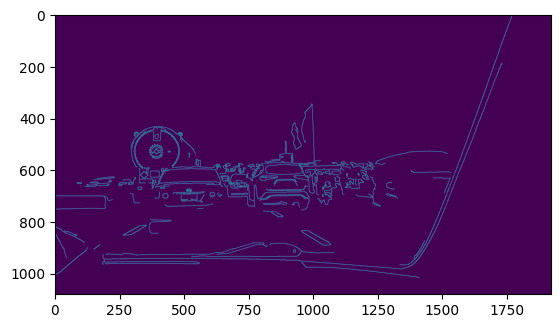

In [ ]:
plt.imshow(plot_lanes(img));